In [1]:
#IMPORT ALL THE REQUIRED LIBERARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Optional: for warnings suppression
import warnings
warnings.filterwarnings('ignore')

# Set visualizations inline
%matplotlib inline


In [2]:
import torch
print(torch.cuda.is_available())
print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))



True
cuda


In [3]:
# Load the dataset (Demographics)
patients = pd.read_csv('PATIENTS.csv.gz')

# Preview the dataset
patients.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [4]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       46520 non-null  int64 
 1   SUBJECT_ID   46520 non-null  int64 
 2   GENDER       46520 non-null  object
 3   DOB          46520 non-null  object
 4   DOD          15759 non-null  object
 5   DOD_HOSP     9974 non-null   object
 6   DOD_SSN      13378 non-null  object
 7   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


In [5]:
# Checking missing values in each column
missing_values_patients = patients.isnull().sum()
missing_values_patients[missing_values_patients > 0]

DOD         30761
DOD_HOSP    36546
DOD_SSN     33142
dtype: int64

In [6]:
# missing values: fill with 'UNKNOWN'
patients['DOD'].fillna('1', inplace=True)
patients['DOD_HOSP'].fillna('1', inplace=True)
patients['DOD_SSN'].fillna('1', inplace=True)

In [7]:
# Check duplicates
duplicates_patients = patients.duplicated().sum()
print(f'Total duplicate rows: {duplicates_patients}')

# Drop duplicates if necessary
patients.drop_duplicates(inplace=True)

Total duplicate rows: 0


In [8]:
# Convert string dates to datetime
patients['DOB'] = pd.to_datetime(patients['DOB'], errors='coerce')
patients['DOD'] = pd.to_datetime(patients['DOD'], errors='coerce')
patients['DOD_HOSP'] = pd.to_datetime(patients['DOD_HOSP'], errors='coerce')
patients['DOD_SSN'] = pd.to_datetime(patients['DOD_SSN'],errors='coerce')
# Verify data types again
print(patients.dtypes)

ROW_ID                  int64
SUBJECT_ID              int64
GENDER                 object
DOB            datetime64[ns]
DOD            datetime64[ns]
DOD_HOSP       datetime64[ns]
DOD_SSN        datetime64[ns]
EXPIRE_FLAG             int64
dtype: object


In [9]:
# Encode categorical columns (e.g., GENDER)
patients['GENDER_CODE'] = patients['GENDER'].astype('category').cat.codes

# Preview encoded values
print(patients[['GENDER', 'GENDER_CODE']].head())


  GENDER  GENDER_CODE
0      F            0
1      F            0
2      M            1
3      M            1
4      F            0


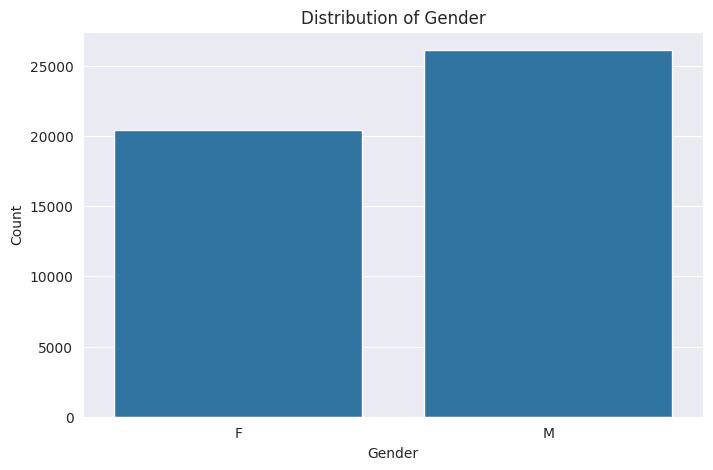

In [10]:
# Visualize GENDER distribution
plt.figure(figsize=(8,5))
sns.countplot(x='GENDER', data=patients)
plt.title("Distribution of Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


In [11]:
# Save cleaned file
patients.to_csv("patients_cleaned.csv", index=False)

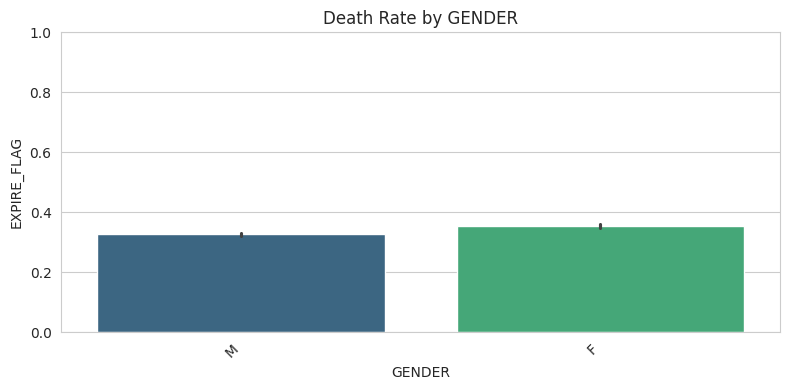

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Auto-select categorical columns (object or category dtype)
cat_cols = patients.select_dtypes(include=['object', 'category']).columns.tolist()

sns.set_style('whitegrid')

for col in cat_cols:
    data = patients[[col, 'EXPIRE_FLAG']].dropna()
    if data[col].nunique() > 25:
        continue
    order = data.groupby(col)['EXPIRE_FLAG'].mean().sort_values().index
    plt.figure(figsize=(8,4))
    sns.barplot(x=col, y='EXPIRE_FLAG', data=data, order=order, palette='viridis')
    plt.title(f"Death Rate by {col}")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [13]:
!pip install sdv


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [14]:
# Imports
import pandas as pd
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

patients_cleaned = pd.read_csv("patients_cleaned.csv")

#  Generate metadata for SINGLE TABLE
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(patients_cleaned)

# Initialize synthesizer (no enforce_minimal in this version)
synthesizer = CTGANSynthesizer(
    metadata=metadata,
    epochs=30,
)

#  Fit the synthesizer to the data
synthesizer.fit(patients_cleaned)

synthetic_same_size = synthesizer.sample(num_rows=len(patients_cleaned))
synthetic_data = synthesizer.sample(num_rows=1000)

#  Save synthetic data
synthetic_data.to_csv("synthetic_patients.csv", index=False)

# Preview
synthetic_data.head()


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,GENDER_CODE
0,4396970,47737,F,2036-10-27,2114-10-08,NaN,NaN,1,0
1,14425973,16420,M,2109-10-29,NaN,NaN,NaN,0,1
2,10759477,45548,F,2139-06-09,NaN,NaN,NaN,1,0
3,3416257,25527,F,2065-12-18,NaN,NaN,NaN,1,0
4,8120207,29938,F,2109-12-31,NaN,NaN,NaN,1,0


In [17]:
print("Synthesizer fitted:", synthesizer._fitted)

Synthesizer fitted: True


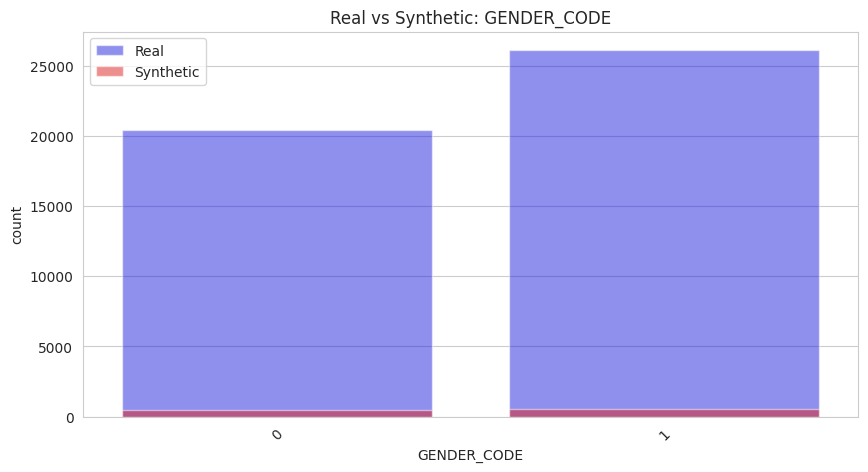

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
# Example: Compare distributions of a categorical column
column = 'GENDER_CODE'

plt.figure(figsize=(10,5))

# Real data
sns.countplot(x=column, data=patients_cleaned, color='blue', label='Real', alpha=0.5)

# Synthetic data
sns.countplot(x=column, data=synthetic_data, color='red', label='Synthetic', alpha=0.5)

plt.legend()
plt.title(f"Real vs Synthetic: {column}")
plt.xticks(rotation=45)
plt.show()

In [23]:
#  Load synthetic dataset if not already in memory
import pandas as pd
import os
synthetic = pd.read_csv("synthetic_patients.csv")

#   Setup for evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Choose features and target
features = ['GENDER_CODE']
target = 'EXPIRE_FLAG'

# Ensure encoding consistency
for col in features:
    patients_cleaned[col] = patients_cleaned[col].astype('category').cat.codes
    synthetic_data[col] = synthetic_data[col].astype('category').cat.codes

# Real data model
X_real = patients_cleaned[features]
y_real = patients_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# Synthetic data model
X_syn = synthetic_data[features]
y_syn = synthetic_data[target]
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f" Model accuracy on real data:     {real_acc:.2f}")
print(f" Model accuracy on synthetic data:  {syn_acc:.2f}")



 Model accuracy on real data:     0.66
 Model accuracy on synthetic data:  0.62


In [25]:

#  Import TVAESynthesizer
from sdv.single_table import TVAESynthesizer

#  Initialize VAE synthesizer
vae_synthesizer = TVAESynthesizer(
    metadata=metadata,
    epochs=10
)

# Fit the VAE synthesizer
vae_synthesizer.fit(patients_cleaned)

#  Sample synthetic data using VAE
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

#  Save VAE synthetic data
synthetic_data_vae.to_csv('synthetic_patients_vae.csv', index=False)

#  Preview VAE synthetic data
synthetic_data_vae.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,GENDER_CODE
0,6625952,10468,F,2055-03-15,2107-07-18,2151-11-20,NaN,1,0
1,8371263,10228,M,2116-01-25,2152-07-22,NaN,280-09-4330,0,1
2,2076715,20328,M,2051-03-18,NaN,NaN,NaN,1,1
3,10976487,12244,M,2071-03-06,NaN,NaN,NaN,0,1
4,5223035,16494,M,2082-09-01,NaN,NaN,NaN,0,1


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load your synthetic data generated from VAE
synthetic_vae = pd.read_csv('synthetic_patients_vae.csv')

# Preprocessing: convert categorical columns to numeric codes 
features = ['GENDER_CODE','DOB']
target = 'EXPIRE_FLAG'

# Make sure all datasets are prepared
for col in features:
    patients_cleaned[col] = patients_cleaned[col].astype('category').cat.codes
    synthetic_vae[col] = synthetic_vae[col].astype('category').cat.codes

# Real data model (already trained if you want, but re-training to be safe)
X_real = patients_cleaned[features]
y_real = patients_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)

model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# VAE Synthetic data model
X_vae = synthetic_vae[features]
y_vae = synthetic_vae[target]
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

# Show results
print(f" Model accuracy on real data:       {real_acc:.2f}")
print(f" Model accuracy on VAE synthetic data: {vae_acc:.2f}")


 Model accuracy on real data:       0.60
 Model accuracy on VAE synthetic data: 0.66


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# === Minimal Planar Flow Layer ===
class PlanarFlow(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.u = nn.Parameter(torch.randn(1, dim))
        self.w = nn.Parameter(torch.randn(1, dim))
        self.b = nn.Parameter(torch.randn(1))

    def forward(self, z):
        h = torch.tanh(torch.matmul(z, self.w.T) + self.b)
        z_new = z + self.u * h
        psi = (1 - h**2) * self.w
        log_det = torch.log(torch.abs(1 + torch.matmul(psi, self.u.T)) + 1e-8)
        return z_new, log_det

# === Flow-VAE Model ===
class FlowVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10, hidden=64):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(nn.Linear(input_dim, hidden), nn.ReLU(), nn.Linear(hidden, hidden), nn.ReLU())
        self.mu = nn.Linear(hidden, latent_dim)
        self.logvar = nn.Linear(hidden, latent_dim)
        self.decoder = nn.Sequential(nn.Linear(latent_dim, hidden), nn.ReLU(), nn.Linear(hidden, input_dim), nn.Sigmoid())
        self.flow = PlanarFlow(latent_dim)

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.mu(h), self.logvar(h)
        std = torch.exp(0.5 * logvar)
        z0 = mu + std * torch.randn_like(std)
        z1, log_det = self.flow(z0)
        x_hat = self.decoder(z1)
        return x_hat, mu, logvar, z0, z1, log_det

# === Loss Function ===
def loss_fn(x, x_hat, mu, logvar, z0, z1, log_det):
    recon = F.binary_cross_entropy(x_hat, x, reduction='sum')
    log_qz0 = -0.5 * torch.sum(logvar + ((z0 - mu)**2) / torch.exp(logvar))
    log_pz1 = -0.5 * torch.sum(z1**2)
    return recon + (log_qz0 - log_pz1 - log_det.sum())


# === Data Preparation ===
features = ['GENDER_CODE','DOB']
target = 'EXPIRE_FLAG'

# Encode categorical features
for col in features + [target]:
    patients_cleaned[col] = LabelEncoder().fit_transform(patients_cleaned[col])

# Convert to torch tensor
from sklearn.preprocessing import MinMaxScaler

# Scale input features to [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(patients_cleaned[features + [target]])

# Convert to tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


# === Model Initialization and Training ===
input_dim = X_tensor.shape[1]
flow_vae_model = FlowVAE(input_dim=input_dim)
optimizer = torch.optim.Adam(flow_vae_model.parameters(), lr=1e-3)

print("Training Flow-VAE...")
for epoch in range(20):
    flow_vae_model.train()
    x_hat, mu, logvar, z0, z1, log_det = flow_vae_model(X_tensor)
    loss = loss_fn(X_tensor, x_hat, mu, logvar, z0, z1, log_det)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.2f}")

# === Synthetic Data Generation ===
print("Generating synthetic data...")
n_samples = 10000
latent_dim = flow_vae_model.latent_dim
z = torch.randn(n_samples, latent_dim)

with torch.no_grad():
    synthetic_tensor = flow_vae_model.decoder(z).cpu()

synthetic_df = pd.DataFrame(synthetic_tensor.numpy(), columns=features + [target])
for col in features + [target]:
    synthetic_df[col] = synthetic_df[col].round().astype(int)

synthetic_df.to_csv("synthetic_patients_flowvae.csv", index=False)
print(" Synthetic data saved to 'synthetic_patients_flowvae.csv'")


Training Flow-VAE...
Epoch 1: Loss = 416871.09
Epoch 2: Loss = 410446.31
Epoch 3: Loss = 405571.56
Epoch 4: Loss = 403910.47
Epoch 5: Loss = 398487.97
Epoch 6: Loss = 398294.00
Epoch 7: Loss = 395748.66
Epoch 8: Loss = 393783.06
Epoch 9: Loss = 391725.12
Epoch 10: Loss = 392722.66
Epoch 11: Loss = 389946.50
Epoch 12: Loss = 388978.69
Epoch 13: Loss = 390285.41
Epoch 14: Loss = 389491.16
Epoch 15: Loss = 389892.81
Epoch 16: Loss = 388179.12
Epoch 17: Loss = 386474.31
Epoch 18: Loss = 387362.12
Epoch 19: Loss = 384457.91
Epoch 20: Loss = 384268.12
Generating synthetic data...
 Synthetic data saved to 'synthetic_patients_flowvae.csv'


In [28]:
import torch
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#  Step 1: Generate Synthetic Data from Trained Flow-VAE 
n_samples = 10000  # adjust as needed
latent_dim = flow_vae_model.latent_dim  # make sure this exists
features = ['GENDER_CODE','DOB']
target = 'EXPIRE_FLAG'

# Generate latent vectors and decode
z = torch.randn(n_samples, latent_dim)
with torch.no_grad():
    synthetic_data_tensor = flow_vae_model.decoder(z).cpu()

# Convert to DataFrame and name columns
synthetic_df = pd.DataFrame(synthetic_data_tensor.numpy(), columns=features + [target])

# Round/convert float columns to int for categorical values
for col in features + [target]:
    synthetic_df[col] = synthetic_df[col].round().astype(int)

# Save the synthetic data (optional, but used below)
synthetic_df.to_csv('synthetic_patients_flowvae.csv', index=False)

# Step 2: Load the Saved Synthetic Data
synthetic_flowvae = pd.read_csv('synthetic_patients_flowvae.csv')

#  Step 3: Encode categorical features consistently 
for col in features:
    patients_cleaned[col] = patients_cleaned[col].astype('category').cat.codes
    synthetic_flowvae[col] = synthetic_flowvae[col].astype('category').cat.codes

#  Step 4: Real Data Model 
X_real = patients_cleaned[features]
y_real = patients_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)

model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# Step 5: Flow-VAE Synthetic Data Model
X_fvae = synthetic_flowvae[features]
y_fvae = synthetic_flowvae[target]
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_fvae, y_fvae, test_size=0.3, random_state=42)

model_fvae = RandomForestClassifier(random_state=42)
model_fvae.fit(Xf_train, yf_train)
fvae_acc = accuracy_score(yf_test, model_fvae.predict(Xf_test))

#Step 6: Print Results
print(f" Model accuracy on real data:          {real_acc:.2f}")
print(f" Model accuracy on Flow-VAE synthetic: {fvae_acc:.2f}")


 Model accuracy on real data:          0.60
 Model accuracy on Flow-VAE synthetic: 0.96


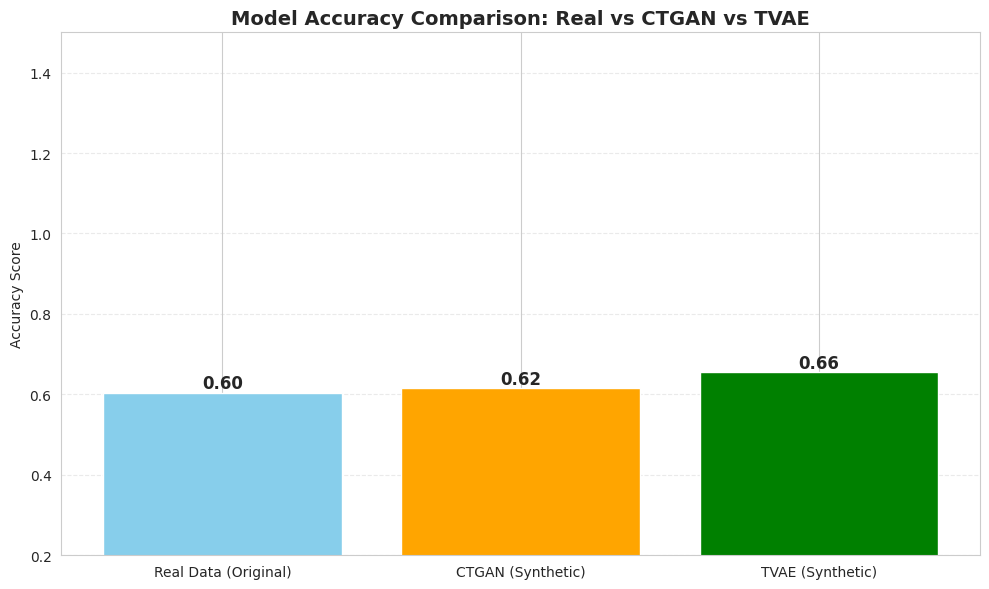

In [29]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
